# TASK 1 PART 1: NON NEGATIVE MATRIX FACTORIZATION

Creating user business matrix and applying a variation of collaborative filtering method where the errors between predictions and true value is minimized using gradient descent

Reference: http://www.quuxlabs.com/blog/2010/09/matrix-factorization-a-simple-tutorial-and-implementation-in-python/

In [1]:
#imports go here
import json
import pandas as pd
import numpy as np
import copy
import random
import pickle
import math
import matplotlib.pyplot as plt

from matplotlib.axes import Axes
from sklearn.model_selection import train_test_split


Data stored in nv_restaurants_reviews.csv consits of reviews for NV based restaurants

Note: Place the nv_restaurants_reviews.csv in the same folder or enter the path

In [3]:
nevada_pickle=pd.read_csv("nv_restaurants_reviews.csv")

In [4]:
review_df_restaurant = nevada_pickle.loc[:, ['business_id', 'user_id','stars']]
len(review_df_restaurant)

1391673

Averaging the ratings at a user business level

In [5]:
review_df_restaurant_avg=review_df_restaurant.groupby(['business_id', 'user_id'], as_index=False).agg({"stars": "mean"})

In [6]:
len(review_df_restaurant_avg)

1348010

In [7]:
review_df_restaurant_avg.head()

,business_id,user_id,stars
0,--9e1ONYQuAa-CB_Rrw7Tw,---1lKK3aKOuomHnwAkAow,4.0
1,--9e1ONYQuAa-CB_Rrw7Tw,-11nMat3F0DgsxT30hn8zA,5.0
2,--9e1ONYQuAa-CB_Rrw7Tw,-3fMaL_ck0wzEsTZyz-mqA,5.0
3,--9e1ONYQuAa-CB_Rrw7Tw,-47EprTYhe9IbAvplGIcpA,5.0
4,--9e1ONYQuAa-CB_Rrw7Tw,-7cPERHtAupd1Xq53nmhXg,5.0


Sparsity Reduction: Using restaurants with reviews > 50 and users who gave reviews for minimum 20 restaurants

In [8]:
BusinessGreaterThan50Reviews = review_df_restaurant_avg.groupby('business_id').filter(lambda x: x['business_id'].count()>50)



In [9]:
BusinessGreaterThan50Reviews.business_id.nunique()

3941

In [10]:
BusinessGreaterThan50Reviews.head()

,business_id,user_id,stars
0,--9e1ONYQuAa-CB_Rrw7Tw,---1lKK3aKOuomHnwAkAow,4.0
1,--9e1ONYQuAa-CB_Rrw7Tw,-11nMat3F0DgsxT30hn8zA,5.0
2,--9e1ONYQuAa-CB_Rrw7Tw,-3fMaL_ck0wzEsTZyz-mqA,5.0
3,--9e1ONYQuAa-CB_Rrw7Tw,-47EprTYhe9IbAvplGIcpA,5.0
4,--9e1ONYQuAa-CB_Rrw7Tw,-7cPERHtAupd1Xq53nmhXg,5.0


In [11]:
UsersGreaterThan20Reviews = BusinessGreaterThan50Reviews.groupby('user_id').filter(lambda x: x['user_id'].count()> 20)

In [12]:
UsersGreaterThan20Reviews.user_id.nunique()

6113

In [13]:
len(UsersGreaterThan20Reviews)

278425

Creating user business matrix:

In [14]:
matrix = UsersGreaterThan20Reviews.pivot(index='user_id', columns='business_id', values='stars').fillna(0)

In [15]:
matrix.shape

(6113, 3940)

TEST SPLIT:

We randomly chose 20 percent of the values in the populated matrix and replaced them with zeros in the matrix. While sampling this 20 percent cells, we made sure of the following:

- Corresponding users have rated atleast one other business
- Corresponding restaurants are rated by atleast one other user

    

In [16]:
#Just to get an idea about the train test split that is supposed to be done
zero_removal = int(0.2 * np.count_nonzero(matrix))

In [17]:
print(np.count_nonzero(matrix),zero_removal)

278425 55685


In [18]:
#Sampling of test and giving them a value of 0

In [19]:
#matrix = [[5,0,0,0],[3,1,2,0],[0,0,3,5],[3,3,1,2],[3,1,2,3]]
array_matrix = np.array(matrix)

row_zero = np.count_nonzero(array_matrix, axis=1)
col_zero = np.count_nonzero(array_matrix, axis=0)
row_nums = dict(enumerate(row_zero))
col_nums = dict(enumerate(col_zero))


#print("Initial Matrix")
#print(array_matrix)
#print(col_nums.keys())

In [20]:
# Get the non-zero samples and make them 0's in train matrix for testing!

import sys
sys.setrecursionlimit(20000)
#LOOP THIS
sample_array = []
sample_count = 0
new_matrix = copy.deepcopy(array_matrix)
non_zero_list = np.nonzero(array_matrix)
non_zero_samples_to_pick = []

for i in range(len(non_zero_list[0])):
    non_zero_samples_to_pick.append([non_zero_list[0][i],non_zero_list[1][i]]) 

def get_sample(non_zero_samples_to_pick,row_nums,col_nums): 
    if len(non_zero_samples_to_pick) <= 0:
        return None
    rand_sample = random.sample(non_zero_samples_to_pick, k=1)
    
    i_val = rand_sample[0][0]
    j_val = rand_sample[0][1]
    
    if(row_nums[i_val]) > 1 and (col_nums[j_val]) > 1:
        
        #sample_count += 1
        sample_array.append([i_val,j_val])
        
        new_matrix[i_val][j_val] = 0
        row_nums[i_val]-=1
        col_nums[j_val]-=1
            
    non_zero_samples_to_pick.remove([i_val,j_val])
    
    #Modify the sample_count to be one third or so.. depending on train test split

for i in range(zero_removal):

    get_sample(non_zero_samples_to_pick,row_nums,col_nums)



In [21]:
user_business_id_test = []
for x,y in sample_array:
    user_business_id_test.append((matrix.index.values[x],matrix.columns[y]))


In [22]:
len(user_business_id_test)

55685

Same data points for test was used across task 1 both parts

In [25]:
'''
import pickle
with open ("user_business_id_test.pkl",'wb') as f:
    pickle.dump(user_business_id_test,f)
'''

In [23]:
'''
with open ("user_business_id_test.pkl",'rb') as f:
    test= pickle.load(f)
'''

'\nwith open ("user_business_id_test.pkl",\'rb\') as f:\n    test= pickle.load(f)\n'

# Matrix Factorization Implementation

- Creating P and Q matrix where K is a tuning parameter
- RMSE is calculated for different K's while training

In [24]:
min_error = float("Inf")
R = np.array(new_matrix)
N = len(R)
M = len(R[0])

In [25]:
def matrix_factorization(R, P, Q, K, alpha,beta,steps = 25):

    Q = Q.T
    for step in range(steps):
        print("Iteration:",step)
        for i,j in R:
            eij = new_matrix[i][j] - np.dot(P[i,:],Q[:,j])
            #print(eij)
                #np.array(P)
            P[i,:] += alpha*(2*eij*Q[:,j])
            P[i,:] -= alpha*beta*P[i,:]
            Q[:,j] += alpha*(2*eij*P[i,:])
            Q[:,j] -= alpha*beta*Q[:,j]

        #eR = np.dot(P,Q)
        e = 0
        for i,j in R:
            e = e + pow(new_matrix[i][j] - np.dot(P[i,:],Q[:,j]), 2)
            
            e = np.sum( (beta/2) * ( np.square(P[i,:]) + np.square(Q[:,j]) ) )
        if e < 0.001:
            break
    nP = P
    nQ = Q.T
    nR = np.dot(nP,nQ.T)

    train_count = np.count_nonzero(R)
    sq_train_error = 0

    for i,j in R:
        sq_train_error += np.square(new_matrix[i][j]-nR[i][j])

    mean_sq_train_error = sq_train_error/train_count
    
    return mean_sq_train_error,nR



In [26]:
after_non_zero_list = np.nonzero(new_matrix)
after_non_zero_samples_to_pick = []

for i in range(len(after_non_zero_list[0])):
    after_non_zero_samples_to_pick.append([after_non_zero_list[0][i],after_non_zero_list[1][i]]) 


In [34]:
#Change the K array accordingly
min_error = float("Inf")
K_array = [100,120,150,180]
final_K_val = K_array[0]
result_array = []

for K in K_array:
    print("K Value : ", K)
    P = np.random.rand(N,K)
    Q = np.random.rand(M,K)
    returned_error, nR_value = matrix_factorization(after_non_zero_samples_to_pick, P, Q, K, .002,.2,steps =30 )
    result_array.append([K,returned_error,nR_value])
    if returned_error < min_error:
        print(returned_error)
        final_K_val = K
        min_error = returned_error
        final_matrix = nR_value

K Value :  100
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
0.20623635655506328
K Value :  120
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
0.18594319390143182
K Value :  150
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iter

In [35]:
test_error=[]

counter = 0
for mat in result_array:
    mat_error = 0
    
    for i in sample_array:
        mat_error += math.pow((array_matrix[i[0]][i[1]]-mat[2][i[0]][i[1]]),2)
    rmse_mat = math.sqrt(mat_error/len(sample_array))
    test_error.append((K_array[counter],rmse_mat))
    counter+=1


print(test_error)

[(100, 1.1153148977361766), (120, 1.1556476997783187), (150, 1.2309959518458604), (180, 1.316463030257482)]


In [36]:
train_error = [(x[0],x[1]) for x in result_array]
print(train_error)

[(100, 0.20623635655506328), (120, 0.18594319390143182), (150, 0.16400932582269015), (180, 0.14917055298125492)]


In [37]:
test_error.sort(key=lambda x:x[0])
train_error.sort(key=lambda x:x[0])
train_errors_sorted = [r[1] for r in train_error]
test_errors_sorted = [r[1] for r in test_error]
k_vals_array = [r[0] for r in train_error]

In [38]:
print(train_error)

[(100, 0.20623635655506328), (120, 0.18594319390143182), (150, 0.16400932582269015), (180, 0.14917055298125492)]


In [39]:
print(test_error)

[(100, 1.1153148977361766), (120, 1.1556476997783187), (150, 1.2309959518458604), (180, 1.316463030257482)]


Plotting Graph with RMSE

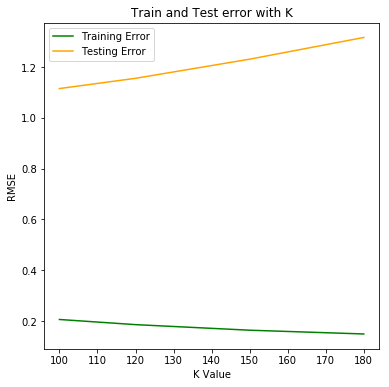

In [40]:
fig, ax = plt.subplots(figsize = (6,6))
ax.plot(k_vals_array, train_errors_sorted, color='green', label='Training Error')
ax.plot(k_vals_array, test_errors_sorted, color='orange', label='Testing Error')
                                   # <--

ax.set_xlabel('K Value')
ax.set_ylabel('RMSE')
ax.set_title('Train and Test error with K')
plt.legend()
plt.show()


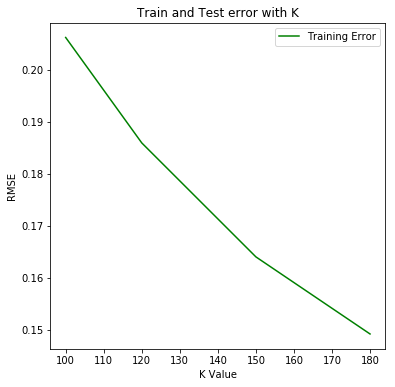

In [41]:
fig, ax = plt.subplots(figsize = (6,6))
ax.plot(k_vals_array, train_errors_sorted, color='green', label='Training Error')


ax.set_xlabel('K Value')
ax.set_ylabel('RMSE')
ax.set_title('Train and Test error with K')
plt.legend()
plt.show()
